# **In the name of deep learning**
* Jinjiu Liu
* Nicola Croce
* Sebastian Wehkamp 
* Tony Dang


# **I. Loading dataset and pretrained weights**

The dataset is downloaded, and the pretrained weights are loaded via dropbox links to the /content folder. If you want to download the weights locally, the folder containing all the weights can be found via this [link](https://www.dropbox.com/sh/8dr48wb5oa5ps3r/AAB6k2DUa1yN-e0I1Koqrwzsa?dl=0).

In [1]:
!wget -nc http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
!tar -xf VOCtrainval_11-May-2009.tar --totals

voc_root_folder = "/content/VOCdevkit/VOC2009"

# classification from scratch
!wget -nc https://www.dropbox.com/s/xd7uahr1pfh7l3i/class_scratch_weights.h5

# classification from transfer learning
!wget -nc https://www.dropbox.com/s/fe82zln2s1iemv3/classification_transfer_learning.h5

# binary segmentation from scratch
!wget -nc https://www.dropbox.com/s/f3sehp3p0whj9ha/model_seg.h5
!wget -nc https://www.dropbox.com/s/887qxm83onfisvu/model_seg.json

# binary segmentation from transfer learning
!wget -nc https://www.dropbox.com/s/917hjtft9z4jv28/seg_TL.h5

# adversarial on training set
!wget -nc https://www.dropbox.com/s/99vz5wbcyenhi2f/GAN_100_trainset_final.h5

# adversarial on test set
!wget -nc https://www.dropbox.com/s/ohja82xyunoqkwl/GAN_100_testset_final.h5

# semantic segmentation from scratch
!wget -nc https://www.dropbox.com/s/arjbz1q5pjsbpot/unet_200ep_catcross.h5

--2020-06-26 13:23:26--  http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 935534080 (892M) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2009.tar’

VOCtrainval_11-May- 100%[===================>] 892.19M  13.8MB/s    in 68s     

2020-06-26 13:24:35 (13.0 MB/s) - ‘VOCtrainval_11-May-2009.tar’ saved [935534080/935534080]

Total bytes read: 935536640 (893MiB, 294MiB/s)
--2020-06-26 13:24:40--  https://www.dropbox.com/s/xd7uahr1pfh7l3i/class_scratch_weights.h5
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.1, 2620:100:601d:1::a27d:501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/xd7uahr1pfh7l3i/class_scratch_weights.h5 [follow

Imports

In [2]:
import os
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, Activation, UpSampling2D, Add, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications, optimizers, regularizers, backend, initializers
from tensorflow.keras.models import model_from_json
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.losses import binary_crossentropy
import pickle

import seaborn as sns
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **II. Building the training and test sets**

VOC dataset does not provide a separate test set, so we'll have to split some of the training/validation set to use as test set. The classification task will focus on classifying images based on containing a person / no person. The segmentation task will focus on background / foreground segmentation.

In [3]:
# Training and validation set with corresponding labels for classification
x_train_class = []
y_train_class = []
x_val_class = []
y_val_class = []

# Training and validation set with corresponding labels for segmentation
train_images_seg = []
train_labels_seg = []
val_images_seg = []
val_labels_seg = []

img_rows = 128
img_cols = 128

# CLASSIFICATION
classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'] 
#         [1          , 2        , 3     , 4     , 5       , 6    , 7    , 8    , 9      , 10   , 11           , 12   , 13     , 14         , 15      , 16           , 17     , 18    , 19     , 20         ]
lines_train = []
files_train = []
lines_val = []
files_val = []
for filename in os.listdir("VOCdevkit/VOC2009/ImageSets/Main"):
    if filename.endswith("_train.txt"):
        file = open("VOCdevkit/VOC2009/ImageSets/Main/" + filename)
        files_train.append(filename.replace("_train.txt",""))
        lines = file.read().splitlines()
        lines_train.append(lines)
    if filename.endswith("_val.txt"):
        file = open("VOCdevkit/VOC2009/ImageSets/Main/" + filename)
        files_val.append(filename.replace("_val.txt",""))
        lines = file.read().splitlines()
        lines_val.append(lines)

def build_binary(lines,files,file_class):
  """
  x: list of np.arrays (size image)
  y: list of integers  (0 or 1)
  """
  x = []
  y = []
  index_class = 0
  for i in range(0,len(lines)):
    if files[i] == file_class:
      index_class = i
      break

  for i in range(0,len(lines[0])):
    [source, label] = lines[index_class][i].split()
    if label == "1":
      y.append(1)
    else: # label == "-1"
      y.append(0)
    img = cv2.imread('VOCdevkit/VOC2009/JPEGImages/' + source + '.jpg')
    x.append(img)
  return x,y

def build_multi_class(lines,files):
  """
  x: list of np.arrays (size image)
  y: list of integers  (1-20)
  """
  x = []
  y = []
  for i in range(0,len(lines[0])):
    label_img = -1
    duplicate = 0
    for j in range(0,len(lines)):
      [source, label] = lines[j][i].split()
      if label == "1":
        if label_img == -1:
          label_img = j
        else:
          duplicate = 1
          break
    # ignore images with duplicates
    if duplicate == 0 and label_img != -1:
      img = cv2.imread('VOCdevkit/VOC2009/JPEGImages/' + source + '.jpg')
      x.append(img)
      for i in range(0,len(classes)):
        if files[label_img] == classes[i]:
          y.append(i+1)
          break
  return x,y

def build_multi_labelled(lines,files):
  """
  x: list of np.arrays (size image)
  y: list of np.arrays (size 1x20)
  """
  x = []
  y = []
  for i in range(0,len(lines[0])):
    y_label = np.zeros((1,20))
    for j in range(0,len(lines)):
      [source, label] = lines[j][i].split()
      if label == "1":
        for k in range(0,len(classes)):
          if files[j] == classes[k]:
            y_label[0,k] = 1
            break
    img = cv2.imread('VOCdevkit/VOC2009/JPEGImages/' + source + '.jpg')
    x.append(img)
    y.append(y_label)
  return x,y

x_train_class, y_train_class = build_binary(lines_train,files_train,"person")
x_val_class, y_val_class = build_binary(lines_val,files_val,"person")

# SEGMENTATION
file_train_seg = open("VOCdevkit/VOC2009/ImageSets/Segmentation/train.txt","r")
train_files = file_train_seg.read().splitlines()

file_val_seg = open("VOCdevkit/VOC2009/ImageSets/Segmentation/val.txt","r")
val_files = file_val_seg.read().splitlines()

for file in train_files:
  img = cv2.imread('VOCdevkit/VOC2009/JPEGImages/' + file + '.jpg')
  img = cv2.resize(img, dsize=(img_rows,img_cols))
  # Uncomment for grayscale
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  #img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

  lab = cv2.imread('VOCdevkit/VOC2009/SegmentationClass/' + file + '.png')
  lab = cv2.resize(lab, dsize=(img_rows,img_cols))

  # Convert to thresholded image
  lab = cv2.cvtColor(lab, cv2.COLOR_BGR2GRAY)
  lab = 255*((lab>0).astype('uint8'))
  lab = cv2.cvtColor(lab, cv2.COLOR_GRAY2BGR)

  train_images_seg.append(img)
  train_labels_seg.append(lab)

for file in val_files:
  img = cv2.imread('VOCdevkit/VOC2009/JPEGImages/' + file + '.jpg')
  img = cv2.resize(img, dsize=(img_rows,img_cols))
  # Uncomment for grayscale
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  #img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

  lab = cv2.imread('VOCdevkit/VOC2009/SegmentationClass/' + file + '.png')
  lab = cv2.resize(lab, dsize=(img_rows,img_cols))
  
  # Convert to thresholded image
  lab = cv2.cvtColor(lab, cv2.COLOR_BGR2GRAY)
  lab = 255*((lab>0).astype('uint8'))
  lab = cv2.cvtColor(lab, cv2.COLOR_GRAY2BGR)

  val_images_seg.append(img)
  val_labels_seg.append(lab)

train_images_seg = np.array(train_images_seg)
train_labels_seg = np.array(train_labels_seg)
val_images_seg = np.array(val_images_seg)
val_labels_seg = np.array(val_labels_seg)

The custom splits are performed in the code block below. For the classification task, 500 images are separated from the training and validation set, to use as test set. For the segmentation task, the validation set will act as a separate test set, since the available training and validation set are quite limited.

classification
--------------


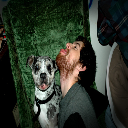

label:  1
images in training set:  3273
images in validation set:  3281
images in test set:  500

segmentation:
--------------


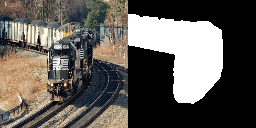

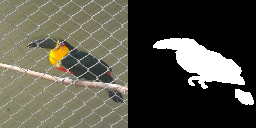

images in training set:  749
images in validation set:  750


In [4]:
np.random.seed(1) # fixed seed

a = list(zip(x_train_class, y_train_class))
np.random.shuffle(a) 
x_train_class, y_train_class = zip(*a)

a = list(zip(x_val_class, y_val_class))
np.random.shuffle(a)
x_val_class, y_val_class = zip(*a)

x_test_class = x_train_class[-200:]+x_val_class[-300:]
y_test_class = y_train_class[-200:]+y_val_class[-300:]
x_train_class = x_train_class[0:-200]
y_train_class = y_train_class[0:-200]
x_val_class = x_val_class[0:-300]
y_val_class = y_val_class[0:-300]

print("classification")
print("--------------")
cv2_imshow(cv2.resize(x_val_class[0], dsize=(img_rows,img_cols)))
print('label: ',y_val_class[0])
print("images in training set: ", len(y_train_class))
print("images in validation set: ", len(y_val_class))
print("images in test set: ", len(y_test_class))

print("\nsegmentation:")
print("--------------")
cv2_imshow(np.concatenate((train_images_seg[10], train_labels_seg[10]), axis=1))
cv2_imshow(np.concatenate((val_images_seg[-1], val_labels_seg[-1]), axis=1))
print("images in training set: ", len(train_labels_seg))
print("images in validation set: ", len(val_labels_seg))

# **III. Classification task**

##a. Architecture


In this section, two convolutional neural networks are built for classifying if there is a person in the image. One of the networks uses pretrained weights from Keras (trained on imagenet), another network is trained from scratch on the training dataset. The output of these two networks is a binary digit. Value 1 indicates that the image contains a person and value 0 indicates it does not. These two convolutional neural networks have the same structure based on the well-known VGG16 network. The last classification layers of the original VGG16 network are removed and replaced with a series of combinations of dense layers and dropout layers. These dropout layers are added to reduce overfit during training. The final activation layer is a sigmoid, which maps the prediction to value between 0-1. This can be interpreted as a confidence index on the presence of a person in the image. The architecture of our networks is shown below. ![CNN architecture](https://drive.google.com/uc?id=1wMy94UzzDme0LuN2INBTnO-tAZ8RaEf4)



As the networks are based on VGG16 mode, many different kinds of layers are involved. They are convolutional layers, max pooling layers, fully-connected layers and drop-out layers. Convolutional layers are used to extract the features of input images. Max pooling layers are aimed to reduce the size of image, thus the computation complexity is reduced. Fully connected layers play a role as a neural network which takes the flattened features as its input and output the final prediction. Drop out layers are applied to avoid the model overfits the training data. Each of the convolutional layer will abstract features of the input images. Those at the beginning part of the network capture simple features over the images, like edges. Those at the latter part of the network capture more complex and sophisticated features. The following compress the features from the convolutional layers and represent them to the final classification layer. Then the classification layer outputs a binary prediction indicating if there is a human being included in the images. The loss function of our classification models is binary cross-entropy loss because it is a binary classification problem.

 

##b. Data preprocessing

Since VGG16 has special requirement for the input size, the images are resized to shape (224,224,3). Then a series of image data generators are created to do image augmentation and output the augmented images. The images of training set are rescaled, and can be randomly sheared and zoomed in range (0, 0.2). The preprocessing of the data is shown in the code block below.

In [5]:
# transfere tule to np array
x_train_data = np.array(x_train_class)
y_train_data = np.array(y_train_class)
x_val_data = np.array(x_val_class)
y_val_data = np.array(y_val_class)
x_test_data = np.array(x_test_class)
y_test_data = np.array(y_test_class)


# resize the images
new_shape = (224,224)
x_train_data_new = np.empty(
                [x_train_data.shape[0], 224, 224, 3], dtype=np.uint8)
for idx in range(x_train_data.shape[0]):
    x_train_data_new[idx] = cv2.resize(x_train_class[idx], new_shape)
print(x_train_data_new.shape)


x_val_data_new = np.empty(
                [x_val_data.shape[0], 224, 224, 3], dtype=np.uint8)
for idx in range(x_val_data.shape[0]):
    x_val_data_new[idx] = cv2.resize(x_val_class[idx], new_shape)
print(x_val_data_new.shape)

x_test_data_new = np.empty(
                [x_test_data.shape[0], 224, 224, 3], dtype=np.uint8)
for idx in range(x_test_data.shape[0]):
    x_test_data_new[idx] = cv2.resize(x_test_class[idx], new_shape)
print(x_test_data_new.shape)

batch_size = 16

# image augmentation generator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_generator = train_datagen.flow(
        x_train_data_new,
        y_train_data,
        batch_size=batch_size)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow(
        x_val_data_new,
        y_val_data,
        batch_size=batch_size)

(3273, 224, 224, 3)
(3281, 224, 224, 3)
(500, 224, 224, 3)


##c. Pretained CNN classifier

In this section, the pretrained weights from imagenet are loaded. The weights of the early layers are frozen. These layers only extract general features from the images, so they are not required to be retrained. The final convolutional layers are more data-specific features and will not be frozen. In this code block, all convolutional layers have been frozen until ```conv5```. As seen in the model summary, in total 7 million parameters have been frozen. You can also see the added classification layers, that were mentioned before.

For transfer learning, it is also important that the initial and target problem are similar enough. Knowledge is transferred from the initial task to the new task. The pretrained network was trained on the imagenet dataset (similar to VOC), hence for our application it is justified to use transfer learning. The VOC dataset is much smaller though. This explains why we froze most of the layers, and apply finetuning on the deeper layers.

In [6]:
vgg16 = applications.VGG16(include_top=False, weights='imagenet', input_shape=(224, 224 ,3))

output = vgg16.layers[-1].output
output = Flatten()(output)
vgg16_model = Model(vgg16.input, output)

vgg16_model.trainable = True

set_trainable = False
for layer in vgg16_model.layers:
    if layer.name in ['block5_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# load pretrained model
input_shape = vgg16_model.output_shape[1]

model_test = Sequential()
model_test.add(vgg16_model)
model_test.add(Dense(512, activation='relu', input_dim=input_shape, kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))
model_test.add(Dropout(0.4))
model_test.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))
model_test.add(Dropout(0.4))
model_test.add(Dense(1, activation='sigmoid'))

model_test.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

model_test.load_weights('/content/classification_transfer_learning.h5')

model_test.summary()

pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg16_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])   

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 25088)             14714688  
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 27,823,425
Trainable params: 20,188,161
Non

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f445c207c18>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4408c91d68>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4408ca9748>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f440846b7b8>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f440846b630>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f440847a6a0>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f4408481b38>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f44084819b0>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4408488cf8>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f440004a438>,block3_conv3,False


##d. Trained-from-scratch CNN classifier

Now here is the part of CNN classifier trained from scratch. It has exactly the same structure of the pretrained one, but all the weights are trainable. The weights are also randomly initialized (```weights=None```). In the model summary, it can be seen now that all parameters are trainable. It is trained on the training set, and the final trained weights are saved. Here to save the training time, the trained weights are loaded and the code for training is commented. It is a rather large model (27 million parameters) and since the VOC dataset is rather small, it tends to be more sensitive to overfitting.

In [7]:
vgg16 = applications.VGG16(include_top=False, weights=None, input_shape=(224, 224 ,3))

output = vgg16.layers[-1].output
output = Flatten()(output)
vgg16_model = Model(vgg16.input, output)

vgg16_model.trainable = True

set_trainable = True
for layer in vgg16_model.layers:
    if layer.name in ['block5_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg16_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])


model_scratch = Sequential()
model_scratch.add(vgg16_model)
input_shape = model_scratch.output_shape[1]

print(input_shape)

model_scratch.add(Dense(512, activation='relu', input_dim=input_shape, kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))
model_scratch.add(Dropout(0.4))
model_scratch.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))
model_scratch.add(Dropout(0.4))
model_scratch.add(Dense(1, activation='sigmoid'))

model_scratch.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

model_scratch.load_weights('/content/class_scratch_weights.h5')
model_scratch.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


25088
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 25088)             14714688  
_________________________________________________________________
dense_3 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 27,823,425
Trainable params: 27,823,425
Non-trainable params: 0
____________________________________

##e. Training of the classification networks

In [8]:
# # logdir = "logs_vgg_new/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights every 5 epochs
# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_path, 
#     verbose=1, 
#     save_weights_only=True,
#     save_freq=204)

# # Save the weights using the `checkpoint_path` format
# model.save_weights(checkpoint_path.format(epoch=0))

# es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)


# history = model.fit(
#     train_generator,
#     steps_per_epoch= len(x_train_data_new)// batch_size,
#     epochs=40,
#     validation_data=validation_generator,
#     validation_steps= len(x_val_data_new) // batch_size,
#     callbacks=[es_callback, cp_callback]
# )

# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss=history.history['loss']
# val_loss=history.history['val_loss']



Since the training process is commented, the training process of these two classification models is saved and discussed here. The models are trained on training set and validation set with batch size 16. Both models monitor the loss on validation set to enable **early stopping**. This is done to reduce overfitting. As a result, the training process of pretrained model stops after 7 epochs. While the training process of the train-from-scratch model reaches its epoch limitation (40 epochs). But it can be seen, that the validation loss was already starting to diverge from the training loss. Both models did not yet show convergence for the training loss, but further training would only make the overfit even larger.

The first figure below is the accuracy and loss of pretrained model on training and validation sets. It already has a good performance in the very beginning, and stops after 6 epochs.

![pretrain](https://drive.google.com/uc?id=1MayI_tx8jE-v1irqzzCqKTMP2dETvTRX)

Next figure shows the learning process of train-from-scratch model. It starts from a random guessing state, and gradually gives better predictions over training. At the end, it reaches a state with 0.7540 accuracy.

![scratch](https://drive.google.com/uc?id=1DYFF12cuxsPqfN3YE36k20ppXmetJ4Iv)

Both models show quite some overfitting. This might be explained because of the small training set.

##f. Analysis and discussion of the performance

The performance of both models is shown below. It is clear that the model trained with transfer learning shows much better accuracy on the test set. This is as expected, since the learning from scratch is only able to learn features from the given training set (which is quite limited). Approximately 40% of the data are images containing a person, the remaining 60% do not contain people. The true negative and true positive rates are printed below as well. This shows that both models are a bit more biased towards classifying the image as a negative. This is especially noticeable for the model learned from scratch. It might be explained by the imbalance of the datasets (20% more images without a person).

In [9]:
print('performance of the classifier trained from scratch: ')
results_scratch = model_scratch.evaluate(x_test_data_new/255, y_test_data, batch_size=16)
prediction_scratch = model_scratch.predict(x_test_data_new/255)
true_pos_scratch = 0; true_neg_scratch = 0; total_pos = 0; total_neg = 0
for i in range(0,len(y_test_data)):
  if y_test_data[i] == 1:
    total_pos += 1
    if prediction_scratch[i]>0.5:
      true_pos_scratch += 1
  else:
    total_neg +=1
    if prediction_scratch[i]<0.5:
      true_neg_scratch += 1
print('true positive rate: ', true_pos_scratch/total_pos)
print('true negative rate: ', true_neg_scratch/total_neg)

print('\nperformance of the classifier trained from transfer learning: ')
results_TL = model_test.evaluate(x_test_data_new/255, y_test_data, batch_size=16)
prediction_TL = model_test.predict(x_test_data_new/255)
true_pos_TL = 0; true_neg_TL = 0; total_pos = 0; total_neg = 0
for i in range(0,len(y_test_data)):
  if y_test_data[i] == 1:
    total_pos += 1
    if prediction_TL[i]>0.5:
      true_pos_TL += 1
  else:
    total_neg +=1
    if prediction_TL[i]<0.5:
      true_neg_TL += 1
print('true positive rate: ', true_pos_TL/total_pos)
print('true negative rate: ', true_neg_TL/total_neg)

performance of the classifier trained from scratch: 
32/32 [==============================] - 2s 48ms/step - loss: 0.7674 - accuracy: 0.7380
true positive rate:  0.5613207547169812
true negative rate:  0.8680555555555556

performance of the classifier trained from transfer learning: 
32/32 [==============================] - 1s 40ms/step - loss: 1.9711 - accuracy: 0.8700
true positive rate:  0.8018867924528302
true negative rate:  0.9201388888888888


In this final section, some examples of predictions are given.

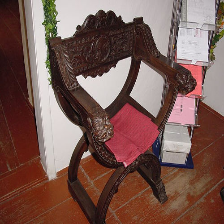

prediction scratch          :  [0.5465921] - ground truth:  0
prediction transfer learning:  [4.6738605e-06] - ground truth:  0


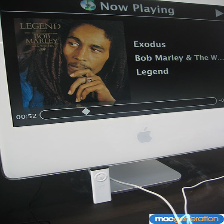

prediction scratch          :  [0.23681483] - ground truth:  1
prediction transfer learning:  [0.99913496] - ground truth:  1


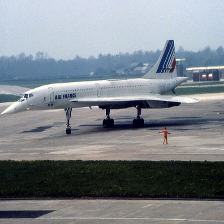

prediction scratch          :  [0.08149993] - ground truth:  1
prediction transfer learning:  [1.29941345e-05] - ground truth:  1


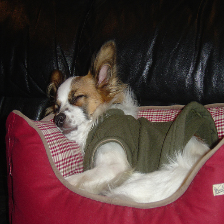

prediction scratch          :  [0.6906354] - ground truth:  0
prediction transfer learning:  [0.27387908] - ground truth:  0


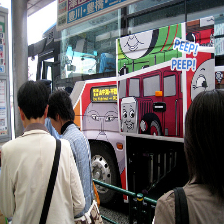

prediction scratch          :  [0.5181] - ground truth:  1
prediction transfer learning:  [0.9999356] - ground truth:  1


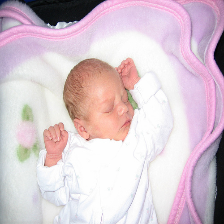

prediction scratch          :  [0.7830567] - ground truth:  1
prediction transfer learning:  [0.99999225] - ground truth:  1


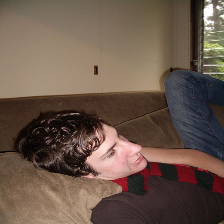

prediction scratch          :  [0.10001377] - ground truth:  1
prediction transfer learning:  [0.04933097] - ground truth:  1


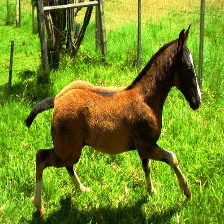

prediction scratch          :  [0.0260012] - ground truth:  0
prediction transfer learning:  [4.568828e-11] - ground truth:  0


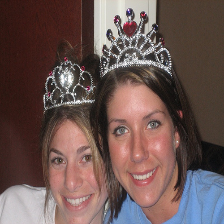

prediction scratch          :  [0.9981177] - ground truth:  1
prediction transfer learning:  [0.99999976] - ground truth:  1


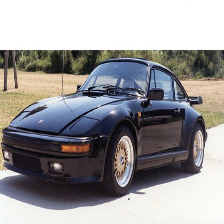

prediction scratch          :  [0.26294243] - ground truth:  0
prediction transfer learning:  [0.01965887] - ground truth:  0


In [10]:
for i in range(0,10):
  cv2_imshow(x_test_data_new[i])
  print("prediction scratch          : ", prediction_scratch[i], "- ground truth: ", y_test_data[i])
  print("prediction transfer learning: ", prediction_TL[i], "- ground truth: ", y_test_data[i])

# **IV. Segmentation task**

For the segmentation task, two models have to be trained. A model learned from scratch and a second model learned using transfer learning. These two models will first be discussed and a comparison between the two will be made in the end. The segmentation task was chosen to be a binary segmentation. First, an attempt was made to achieve semantic segmentation, but the results were not very good. These results are shown at the end of the notebook in Section "VII. Extra: multi-class semantic segmentation". Hence, binary segmentation (or background-foreground segmentation) was implemented instead.

The training and validation images were resized in Section II. No additional augmentations were performed. 

##a. Segmentation from scratch

### Specify dice score and loss function
The Dice similarity coefficient, also known as the Sørensen–Dice index or simply Dice coefficient, is a statistical function measuring the similarity between two sets of data. It is defined as the size of overlap of the two segmentations divided by the total size of the two objects. It is one of the most popular metric in the field of image segmentation.


In [11]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

### Define the model

The model follows an encoder-decoder structure where the encoder consists of blocks using a convolutional layer - normalization - activation - max pooling and the decoder convolutional layer - normalization - activation - upsampling. This network is trained for 25 epochs with a batch size of 32. For the losses the dice coefficient is used. This similarity metric between two samples tends to retain sensitivity in heterogeneous samples (such as images) and gives less weight to outliers. No skip connections were used as the sequential API has no support for this.

The network used for segmentation has a different structure from the classification network. The classification network has a form of the encoder followed by a classification part consisting of some dense layers. This is different from the segmentation network which is an encoder followed by a decoder with a sigmoid activation at the end. 

In [12]:
n_epochs = 25
batch_size = 32
# Define the model
model = Sequential()

# Encoder
#1st convolution layer
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(img_rows,img_cols,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#2nd convolution layer
model.add(Conv2D(32,(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#3rd convolution layer
model.add(Conv2D(16,(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#Decoder
#4th convolution layer
model.add(Conv2D(16,(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

#5th convolution layer
model.add(Conv2D(32,(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

#6th convolution layer
model.add(Conv2D(64,(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

# Output
model.add(Conv2D(3,(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))

model.summary()


print(model.summary())

# Compile model
model.compile(optimizer='adadelta',
              loss=[dice_coef_loss],
              metrics=[dice_coef])

# # Fit the model to train images and binary segmented labels
# fitres = model.fit(train_images_seg, train_labels_seg,epochs=n_epochs,batch_size=batch_size,shuffle=True,validation_data=(val_images_seg, val_labels_seg))

# # Save the model
# model.save_weights("model_seg.h5")
# json = model.to_json()
# with open("model_seg.json", "w") as json_file:
#     json_file.write(json)
# print("Saved model to disk")


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)       

### Training of the model

![alt text](https://drive.google.com/uc?id=1mVar-nu8TX4eemsvp0tSfoNAzoL3_Q0U)

The plots shows the training and validation loss based on the dice coefficient. Both the training and validation loss have a steady decrease until around epoch 25 where it starts to stabilise. 

### Load model

This code block first loads the structure of the model from the json and then loads the weights as well.

In [13]:
# Load model
json = open('/content/model_seg.json')
loaded_model_json = json.read()
json.close()
model = model_from_json(loaded_model_json)

# Load weights
model.load_weights('/content/model_seg.h5')

# Show that model is loaded
print(model.summary())
print('Model loaded!')

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_113 (Conv2D)          (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization_113 (Bat (None, 128, 128, 64)      256       
_________________________________________________________________
activation_113 (Activation)  (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 64, 64, 32)        18464     
_________________________________________________________________
batch_normalization_114 (Bat (None, 64, 64, 32)        128       
_________________________________________________________________
activation_114 (Activation)  (None, 64, 64, 32)      

### Model prediction

First some good examples are shown. From left to right the images show the original image, likelihoods, true data, thresholded likelihood, and the prediction. All three examples have the correct object in focus and contain little to no noise outside of the prediction as was shown in the likelihood image. 

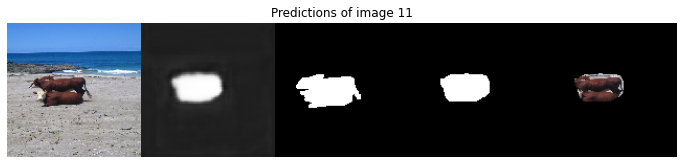

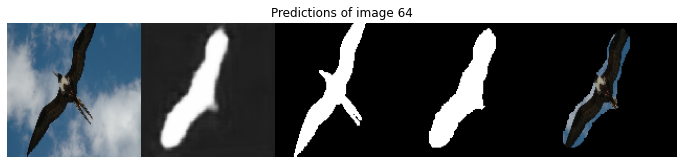

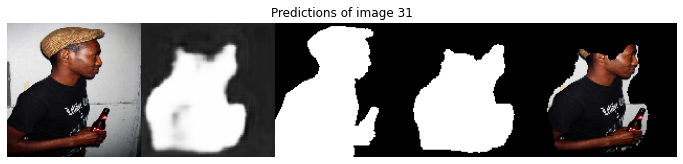

In [14]:
label_test_pred = model.predict(val_images_seg)

img_nr = 11
pred = cv2.cvtColor(label_test_pred[img_nr], cv2.COLOR_BGR2GRAY)
mask = (pred*255).astype('uint8')
mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
pred = ((pred>0.5)*255).astype('uint8')
pred = cv2.cvtColor(pred, cv2.COLOR_GRAY2BGR)
img = np.concatenate((val_images_seg[img_nr], mask, val_labels_seg[img_nr], pred,cv2.subtract(val_images_seg[img_nr],255-pred)), axis=1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,60))
plt.axis('off')
plt.title("Predictions of image " + str(img_nr))
plt.imshow(img)
plt.show()

img_nr = 64
pred = cv2.cvtColor(label_test_pred[img_nr], cv2.COLOR_BGR2GRAY)
mask = (pred*255).astype('uint8')
mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
pred = 255*((pred>0.5).astype('uint8'))
pred = cv2.cvtColor(pred, cv2.COLOR_GRAY2BGR)
img = np.concatenate((val_images_seg[img_nr], mask, val_labels_seg[img_nr], pred, cv2.subtract(val_images_seg[img_nr],255-pred)), axis=1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,60))
plt.axis('off')
plt.title("Predictions of image " + str(img_nr))
plt.imshow(img)
plt.show()

img_nr = 31
pred = cv2.cvtColor(label_test_pred[img_nr], cv2.COLOR_BGR2GRAY)
mask = (pred*255).astype('uint8')
mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
pred = 255*((pred>0.5).astype('uint8'))
pred = cv2.cvtColor(pred, cv2.COLOR_GRAY2BGR)
img = np.concatenate((val_images_seg[img_nr], mask, val_labels_seg[img_nr], pred,cv2.subtract(val_images_seg[img_nr],255-pred)), axis=1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,60))
plt.axis('off')
plt.title("Predictions of image " + str(img_nr))
plt.imshow(img)
plt.show()

This section will show some bad predicitions. The order of the images is the same as with the good examples. For the first image prediction some of the predicted location overlap with the true data but the shape is completely different overall. The second image has two people standing very close to the camera while they are photographing a train. However the prediction perfectly captures the train (part of the background) and the camera used but skips the two persons. The third image shows a person sitting close to the camera. Although the prediction is correct it does not capture the complete region. It is clear that the model, has more trouble segmenting the foreground from the background when the images are more ***cluttered***. In the good examples, the images showed almost no cluttering.

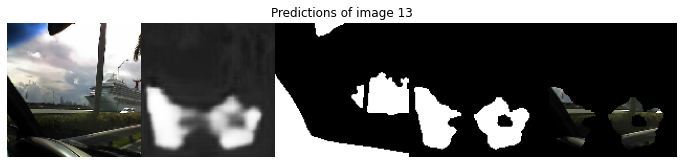

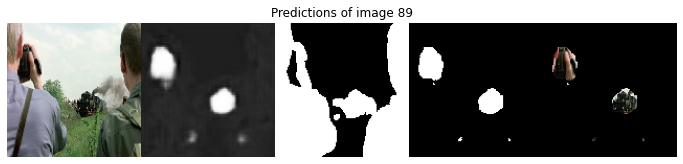

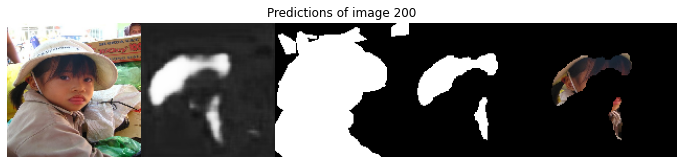

In [15]:
label_test_pred = model.predict(val_images_seg)

img_nr = 13
pred = cv2.cvtColor(label_test_pred[img_nr], cv2.COLOR_BGR2GRAY)
mask = (pred*255).astype('uint8')
mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
pred = ((pred>0.5)*255).astype('uint8')
pred = cv2.cvtColor(pred, cv2.COLOR_GRAY2BGR)
img = np.concatenate((val_images_seg[img_nr], mask, val_labels_seg[img_nr], pred,cv2.subtract(val_images_seg[img_nr],255-pred)), axis=1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,60))
plt.axis('off')
plt.title("Predictions of image " + str(img_nr))
plt.imshow(img)
plt.show()

img_nr = 89
pred = cv2.cvtColor(label_test_pred[img_nr], cv2.COLOR_BGR2GRAY)
mask = (pred*255).astype('uint8')
mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
pred = 255*((pred>0.5).astype('uint8'))
pred = cv2.cvtColor(pred, cv2.COLOR_GRAY2BGR)
img = np.concatenate((val_images_seg[img_nr], mask, val_labels_seg[img_nr], pred, cv2.subtract(val_images_seg[img_nr],255-pred)), axis=1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,60))
plt.axis('off')
plt.title("Predictions of image " + str(img_nr))
plt.imshow(img)
plt.show()

img_nr = 200
pred = cv2.cvtColor(label_test_pred[img_nr], cv2.COLOR_BGR2GRAY)
mask = (pred*255).astype('uint8')
mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
pred = 255*((pred>0.5).astype('uint8'))
pred = cv2.cvtColor(pred, cv2.COLOR_GRAY2BGR)
img = np.concatenate((val_images_seg[img_nr], mask, val_labels_seg[img_nr], pred,cv2.subtract(val_images_seg[img_nr],255-pred)), axis=1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,60))
plt.axis('off')
plt.title("Predictions of image " + str(img_nr))
plt.imshow(img)
plt.show()

##b. Segmentation with transfer learning


### Architecture

For the transfer learning task, the structure of U-Net is used. U-Net is a network originally developped by Olaf Ronneberger et al. for Bio Medical Image Segmentation. As can be seen the general structure of the network is very similar to the network used in the "segmentation from scratch" part. A difference is the skip connection used which were not included in the segmentation from scratch. Skip connections are very useful in encoder-decoder architectures. The information captured in the earlier layers can be used for reconstruction during the decoding part. If these skip connections are not implemented, this information is lost. This is already a huge difference w.r.t. the model trained from scratch.

For transfer learning, it is also important that the initial and target problem are similar enough. Knowledge is transferred from the initial task to the new task. The pretrained network was trained on the imagenet dataset (similar to VOC), hence for our application it is justified to use transfer learning.

![alt text](https://drive.google.com/uc?id=1inMeRv8JbImBmt2DqXBdMz9BFDmqkMTg)

(*Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for biomedical image segmentation." International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.*)

In [16]:
!pip install segmentation-models

### Jaccard loss and Jaccard index

As explained, the U-Net architecture is used. The backbone CNN for extracting the features, was chosen to be Resnet34. In the following code block, this model is loaded and the encoder_weights, trained on imagenet, are used. These layers were frozen for the transfer learning task. Note that ```classes``` is set to 1, since we only do a background vs foreground segmentation.

The used metric is the Jaccard index (or Intersection over Union score). It is a measure to compare the similarity between two sets:
$$ J(A,B) =\frac{A \cap B}{A \cup B} $$

The loss used for this network is the Jaccard loss and is simply defined as follow:
$$ L(A,B) = 1-\frac{A \cap B}{A \cup B} $$

This score is very similar to the dice score used in the training from scratch and a given Jaccard score can be converted to a dice score with: $$S = \frac{2J}{1+J}$$



In [17]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score


BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)
train_images_seg = preprocess_input(train_images_seg)
val_images_seg = preprocess_input(val_images_seg)

n_epochs = 100
batch_size = 32


# define model
model_seg_TL = Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze=True, classes=1,activation='sigmoid',decoder_use_batchnorm=True)
model_seg_TL.compile(optimizer='Adam',
              loss=[bce_jaccard_loss],
              metrics=[iou_score])

# pd.set_option('max_colwidth', -1)
# layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
# pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])   

# model.summary()

# fitres = model.fit(train_images_seg/255, train_labels_seg/255,epochs=100,batch_size=batch_size,shuffle=True,validation_data=(val_images_seg/255, val_labels_seg/255))

Segmentation Models: using `keras` framework.
85524480/85521592 [==============================] - 1s 0us/step


### Training of the model

![alt text](https://drive.google.com/uc?id=1Vxq7CfxPs2N2jB_b8LrHMQAWC5KcwKP8)

It is clearly visible that a lot of overfit is present during the training. After 40 epochs, the training showed no improvement anymore on the validation set. Hence, 100 epochs is a bit excessive in hindsight. What is interesting, is that the training seemed to get stuck in a local minimum between epoch 0-20 for the validation set. After 20 epochs, the loss on the validation set again decreased.

### Load model


In [18]:
model_seg_TL.load_weights('/content/seg_TL.h5')

### Model predictions

Some examples of the predictions on the validation set is given below. It is clear that the overall performance of the model trained from transfer learning is somewhat better than the performance of the model trained from scratch. The results on the same examples used for the model from scratch are shown. For the 'bad examples', it shows slightly better results, but it is still somewhat suffering due to the cluttering in the images. For a background-foreground segmentation task, it might be a good idea to perform an erosion-dilation operation on the output.

However, note that the data used is not optimal for the background-foreground task, but rather for semantic or instance segmentation tasks. In some images, it is hard to objectively say what belongs to the foreground and what belongs to the background. For example, in the "bad example" of the train. The model predicts that the train is not part of the foreground, which could be considered a correct prediction. However, the ground truth shows the train being part of the foreground. This shows that the available data is not optimal for such binary segmentations.

Original image - Ground truth - Output

Good examples:


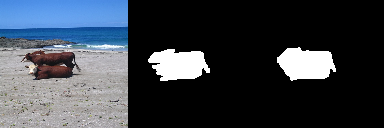

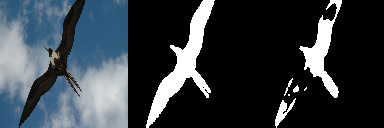

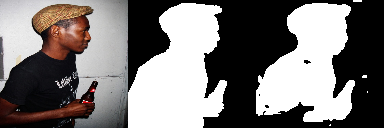


Bad examples:


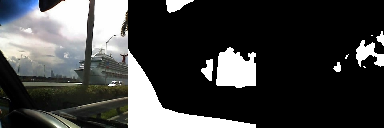

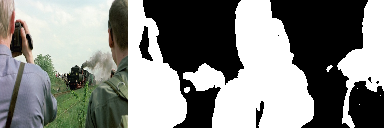

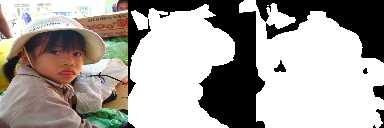

In [19]:
label_test_pred = model_seg_TL.predict(val_images_seg/255)

print('Original image - Ground truth - Output\n')

print('Good examples:')
for i in [11, 64, 31]:
  lab = label_test_pred[i]
  lab = 255*((lab>0.5).astype('uint8'))
  cv2_imshow(np.concatenate((val_images_seg[i], val_labels_seg[i],cv2.merge((lab,lab,lab))), axis=1))

print('\nBad examples:')
for i in [13, 89, 200]:
  lab = label_test_pred[i]
  lab = 255*((lab>0.5).astype('uint8'))
  cv2_imshow(np.concatenate((val_images_seg[i], val_labels_seg[i],cv2.merge((lab,lab,lab))), axis=1))

Some additional results are shown below

Original image - Ground truth - Output



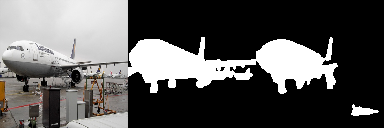

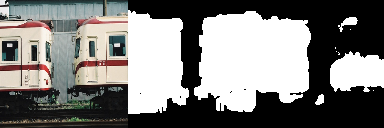

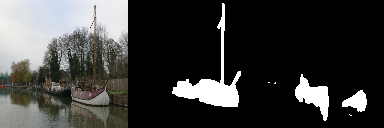

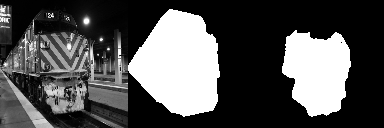

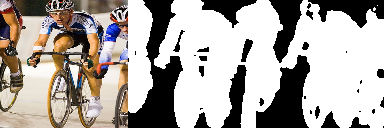

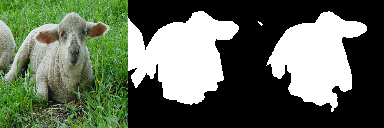

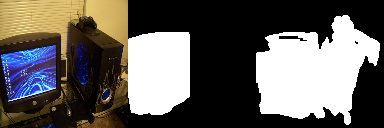

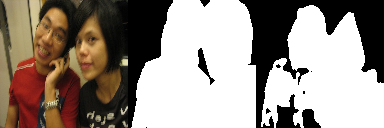

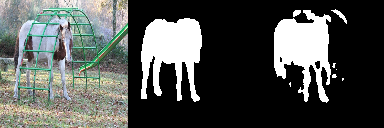

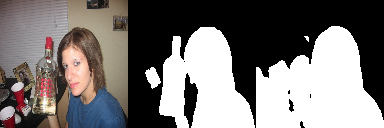

In [20]:
print('Original image - Ground truth - Output\n')
for i in range(0,10):
  lab = label_test_pred[i]
  lab = 255*((lab>0.5).astype('uint8'))
  cv2_imshow(np.concatenate((val_images_seg[i], val_labels_seg[i],cv2.merge((lab,lab,lab))), axis=1))

# **V. Adversarial task**

In this chapter, the task is to generate adversarial examples in an attempt to fool the trained classifier net work from the first task. These adversarial examples will be created by generating subtile perturbations using an encoder-decoder network. These perturbations are then added to the original image. This modified image will then be fed to the classifier in an attempt to fool the classifier. Note that the implemented approach is a white-box attack, since the weights and biases of the targeted classifier are known and can be used for the backpropagation. The steps to achieve this are summarized below:
* Load the pretrained classifier and freeze its weights.
* Build the encoder-decoder network to generate the perturbations.
* Build the complete adversarial network by combining the encoder-decoder with the pretrained classifier.
* Generate deceptive labels based on the available data.
* Train the adversarial network on the training data of the classifier and the test data of the classifier.
* Analyse the performance.

These steps will be discussed in detail in the next sections.

##a. Loading the pretrained classifier

In the following code block, the architecture of the classifier is initialized. Similarly to task 1, the VGG16 architecture, where the top layers are excluded. This classifier architecture will be used to train the adversarial network on.

In [21]:
vgg16 = applications.VGG16(include_top=False, weights=None, input_shape=(224, 224 ,3))

output = vgg16.layers[-1].output
output = Flatten()(output)
vgg16_model = Model(vgg16.input, output)
vgg16_model.trainable = True
    
import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg16_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if __name__ == '__main__':


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f4408fe3b70>,input_3,True
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f416ea36358>,block1_conv1,True
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f416ea369e8>,block1_conv2,True
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f44097276a0>,block1_pool,True
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4372062748>,block2_conv1,True
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4171f68c88>,block2_conv2,True
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f416ea913c8>,block2_pool,True
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f43725e9c50>,block3_conv1,True
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f43725e9dd8>,block3_conv2,True
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4372660588>,block3_conv3,True


The architecture has been initialized correctly. Now, the top layers are added and the pretrained weights from task 1 are loaded. The weights resulting from the training from scratch are used. It is important to freeze these weights in order to not train the classifier further.

In [22]:
# load pretrained model
input_shape = vgg16_model.output_shape[1]

model_test = Sequential()
model_test.add(vgg16_model)
model_test.add(Dense(512, activation='relu', input_dim=input_shape, kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))
model_test.add(Dropout(0.4))
model_test.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))
model_test.add(Dropout(0.4))
model_test.add(Dense(1, activation='sigmoid'))

model_test.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

model_test.load_weights('/content/class_scratch_weights.h5')

model_test.trainable = False
model_test.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 25088)             14714688  
_________________________________________________________________
dense_6 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 27,823,425
Trainable params: 0
Non-trainable params: 27,823,425
__________________________________________

##b. Building the encoder-decoder architecture to generate perturbations

In this section, the encoder-decoder architecture is built. A basic convolutional encoder-decoder without skip connections is chosen to map the input image to a perturbation. Some specific design choices were made:
* The generated perturbations have to remain small such that the original images are still recognizable. This can be achieved by adding regularization terms to the loss. In keras, it is possible to penalize the weights $w$, the biases $b$ or the linear output $y=w^\top x + b$. For this architecture, an L2-norm regularization term $\frac{\lambda}{2}||w^\top x + b||^2_2$ is chosen to limit the perturbations, as it directly regularizes the output of the layer. In practice, regularizations are often used to reduce overfitting.
* No batch normalization layers are added to the architecture. Batch normalization means that for each mini-batch, the mean and variance at the layer are computed, and these are used to normalize the data from that mini-batch at that layer. While this is very useful to improve robustness (it can be interpreted as adding random noise to the data, since the means and variances are different for every mini-batch), the addition of batch normalization did not guarantee a limited perturbation anymore, due to the normalization. Hence, these batch normalization layers have to be avoided for our purpose. Instead, to improve robustness and avoid overfitting, dropout layers are added.
* Another notable design choice is that only ReLu activation layers are used. Using a sigmoid results in undesirable behaviour, as such activation layers map the output between 0 and 1. Very small inputs however are then mapped to values of approximately 0.5. This is again undesirable since the end goal is to achieve small perturbations (close to 0). For ReLu activation layers, small inputs are mapped to small outputs, as desired. This explains why only ReLu activation layers are chosen.

The convolutional encoder-decoder is visualized in the figure below.

![alt text](https://drive.google.com/uc?id=1TgF-Qm7FamTGVCUCYa3Xze7xgtoaF4_h)

In [23]:
model_enc_dec = Sequential()

initializer = initializers.RandomNormal(mean=0., stddev=0.05)

# Encoder
#1st convolution layer
model_enc_dec.add(Conv2D(64, (3, 3), padding='same',kernel_initializer=initializer, bias_initializer='zeros', activity_regularizer=regularizers.l2(0.0001), input_shape=(224,224,3)))
model_enc_dec.add(Activation('relu'))
model_enc_dec.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model_enc_dec.add(Dropout(0.1))

#2nd convolution layer
model_enc_dec.add(Conv2D(32,(3, 3), padding='same',kernel_initializer=initializer, bias_initializer='zeros', activity_regularizer=regularizers.l2(0.0001)))
model_enc_dec.add(Activation('relu'))
model_enc_dec.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model_enc_dec.add(Dropout(0.1))

#3rd convolution layer
model_enc_dec.add(Conv2D(16,(3, 3), padding='same',kernel_initializer=initializer, bias_initializer='zeros', activity_regularizer=regularizers.l2(0.0001)))
model_enc_dec.add(Activation('relu'))
model_enc_dec.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model_enc_dec.add(Dropout(0.1))

#Decoder
#4th convolution layer
model_enc_dec.add(Conv2D(16,(3, 3), padding='same',kernel_initializer=initializer, bias_initializer='zeros', activity_regularizer=regularizers.l2(0.0001)))
model_enc_dec.add(Activation('relu'))
model_enc_dec.add(UpSampling2D((2, 2)))
model_enc_dec.add(Dropout(0.1))

#5th convolution layer
model_enc_dec.add(Conv2D(32,(3, 3), padding='same',kernel_initializer=initializer, bias_initializer='zeros', activity_regularizer=regularizers.l2(0.0001)))
model_enc_dec.add(Activation('relu'))
model_enc_dec.add(UpSampling2D((2, 2)))
model_enc_dec.add(Dropout(0.1))

#6th convolution layer
model_enc_dec.add(Conv2D(64,(3, 3), padding='same',kernel_initializer=initializer, bias_initializer='zeros', activity_regularizer=regularizers.l2(0.0001)))
model_enc_dec.add(Activation('relu'))
model_enc_dec.add(UpSampling2D((2, 2)))
model_enc_dec.add(Dropout(0.1))

#7th convolution layer (Output)
model_enc_dec.add(Conv2D(3,(3, 3), padding='same',kernel_initializer=initializer, bias_initializer='zeros', activity_regularizer=regularizers.l2(0.005)))
model_enc_dec.add(Activation('relu'))

model_enc_dec.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
activation_7 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 112, 112, 32)      18464     
_________________________________________________________________
activation_8 (Activation)    (None, 112, 112, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)       

##c. Building the adversarial network

The encoder-decoder architecture has now been defined. The final step in building the adversarial network is to combine the encoder-decoder network with the pretrained classifier. The complete structure is shown in the figure below, where $X$ is the input image, $f_{\theta a}(X)$ is the encoder-decoder discussed previously. $\delta$ is the generated perturbation, which is then added with the original image to generate the modified image $X+\delta$. This modified image is then fed to the pretrained classifier $h_{\theta c}(X+\delta)$. The weights of this network are frozen. This complete architecture is also given in the code block below. Additionally, the loss function is given with $L(y_{\text{dec}}, h_{\theta c}(X+\delta))$ the normal loss and $R(\delta)$ the regularization term:

$$L_{\text{total}} = L(y_{\text{dec}}, h_{\theta c}(X+\delta)) + R(\delta)\\ \hspace{7.15cm} = - \frac{1}{n} \sum_{i=1}^{n} y^{(i)} \ln{a(x^{(i)})} + (1- y^{(i)}) \ln(1-a(x^{(i)})) + R(\delta)$$

Where the labels $y$ used for the training of the adversarial network are $y_\text{dec}$. These labels will be explained further. The loss function used is the binary-cross entropy loss. This will also be explained further. Note that this is a **white-box attack**. When training the adversarial network, the backpropagation travels through all the weights and biases of the pretrained classifier (weights and biases are known!). This means that information on the classifier will be used to train our adversarial network.

![alt text](https://drive.google.com/uc?id=1MGsacdSFpnMGtBFuiFqvyxqN7ONWscLs)

Remark: two adversarial networks are initialized in the code block, because a comparison will be made between the adversarial network trained on the training data of the classifier, and the adversarial network trained on the test data of the classifier.


In [24]:
from tensorflow.python.keras import backend as back

# input for base image
image = Input(shape=(224,224,3),name='image')

# encoder decoder
f = model_enc_dec(image)

# add noise to image
addition = Add(name='add')([1*f,image])

# feed to classifier 
outputs = model_test(addition)

adversarial_model1 = Model(inputs=image, outputs=outputs)
adversarial_model1.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

adversarial_model2 = Model(inputs=image, outputs=outputs)
adversarial_model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

adversarial_model1.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 224, 224, 3)  52067       image[0][0]                      
__________________________________________________________________________________________________
tf_op_layer_Mul (TensorFlowOpLa [(None, 224, 224, 3) 0           sequential_4[1][0]               
__________________________________________________________________________________________________
add (Add)                       (None, 224, 224, 3)  0           tf_op_layer_Mul[0][0]            
                                                                 image[0][0]                

##d. Generating the deceptive labels

Since the task of the classifier was simply to identify if there's a person in the image or not, the required deceptive labels for the adversarial network are very straightforward. The adversarial network's task is to force the classifier to make the opposite decision. An image of a person should be classified as no person and vice versa. These deceptive labels are easily created by $y_\text{dec}=1-y_\text{ground truth}$. The normal loss for the training of the CNN will also be the binary cross entropy loss.

For multi-label classification, it might be a bit more difficult. Reversing one label of a specific class might not give the desired results. The adversarial network might try to further improve classification on other classes while neglecting the adversarial task. Since this notebook only concerns binary classification, this is not something to worry about in our case.

In [25]:
# transfere tule to np array
x_train_data = np.array(x_train_class)
y_train_data = np.array(y_train_class)
x_val_data = np.array(x_val_class)
y_val_data = np.array(y_val_class)
x_test_data = np.array(x_test_class)
y_test_data = np.array(y_test_class)

y_train_data_deceptive = 1-y_train_data
y_val_data_deceptive = 1-y_val_data
y_test_data_deceptive = 1-y_test_data

In [26]:
# resize the images
new_shape = (224,224)
x_train_data_new = np.empty(
                [x_train_data.shape[0], 224, 224, 3], dtype=np.uint8)
for idx in range(x_train_data.shape[0]):
    x_train_data_new[idx] = cv2.resize(x_train_class[idx], new_shape)
print(x_train_data_new.shape)


x_val_data_new = np.empty(
                [x_val_data.shape[0], 224, 224, 3], dtype=np.uint8)
for idx in range(x_val_data.shape[0]):
    x_val_data_new[idx] = cv2.resize(x_val_class[idx], new_shape)
print(x_val_data_new.shape)

x_test_data_new = np.empty(
                [x_test_data.shape[0], 224, 224, 3], dtype=np.uint8)
for idx in range(x_test_data.shape[0]):
    x_test_data_new[idx] = cv2.resize(x_test_class[idx], new_shape)
print(x_test_data_new.shape)

(3273, 224, 224, 3)
(3281, 224, 224, 3)
(500, 224, 224, 3)


In [27]:
batch_size = 32

# image augmentation generator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_generator = train_datagen.flow(
        x_train_data_new,
        y_train_data_deceptive,
        batch_size=batch_size)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow(
        x_val_data_new,
        y_val_data_deceptive,
        batch_size=batch_size)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = validation_datagen.flow(
        x_test_data_new,
        y_test_data_deceptive,
        batch_size=batch_size)


##e. Training of the adversarial network

The following code block is commented, because the training phase has already been executed. The resulting weights will be loaded in the next section. 100 epochs are planned for the model training, however to avoid overfitting, a callback for early stopping is implemented. Whenever the loss on the validation starts increasing consistently, the training is stopped. 

2 models were trained: 1 model using the training data of the classifier as training data and 1 model using the validation data of the classifier as training data. This was done because our data splitting was quite unbalanced. There are roughly 3300 images in the training set and validation set of the classifier, and only 500 images in the test set for the classifier. To make the comparision more fair, the validation set is used instead of the test set. This won't influence the analysis in the next section, since the validation set can also be considered as "unseen images" for the classifier. Even though images in the validation set are used to steer the training in the right direction by tuning the hyperparameters, the images are never directly used for the training of the weights and biases. As quoted from the assignment: "*it should be enough to demonstrate your performance on the val data*".

The visualization of the loss and accuracy of the adversarial model trained on the training data of the classifier is shown below (the validation set of the classifier is also used as a validation set for the adversarial network).

![loss1](https://drive.google.com/uc?id=1X1fw3ZtXAStIAIr8X03D9QWFpAMYunIr)

The visualization of the loss and accuracy of the adversarial model trained on the validation set of the classifier is shown below (here, the training set of the classifier is used as a validation set for the adversarial network).

![alt text](https://drive.google.com/uc?id=1E6XPJl9r5matep6JFND7rTvalr_MWhlV)

The training in both cases were stopped early approximately at the 80th epoch. It is clear that the accuracy on the training set of the classifier will be lower than the accuracy on the validation set. This is because the classifier has already seen the images in the training set, making it harder to fool the classifier on these images. This intuition will be important later.

In [28]:
# from datetime import datetime
# # logdir = "logs_vgg_new/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights every 5 epochs
# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_path, 
#     verbose=1, 
#     save_weights_only=True,
#     save_freq=1020)

# # Save the weights using the `checkpoint_path` format
# adversarial_model.save_weights(checkpoint_path.format(epoch=0))

# es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# history = adversarial_model.fit(
#     validation_generator,
#     steps_per_epoch= len(x_train_data_new)// batch_size,
#     epochs=100,
#     callbacks=[cp_callback,es_callback],
#     validation_data=train_generator,
#     validation_steps= len(x_train_data_new) // batch_size
# )

# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss=history.history['loss']
# val_loss=history.history['val_loss']

# from matplotlib import pyplot as plt

# epochs_range = range(len(acc))

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.savefig("GAN_100_trainset_final.pdf")

##f. Analysis of the performance and the perturbations

In the following code block, the weights from the trained adversarial networks are loaded. ``adversarial_model1`` refers to the model trained on the training set of the classifier and ``adversarial_model2`` refers to the adversarial model trained on the validation set of the classifier. Using a test set, the modified images are now extracted from the adversarial network. This is useful for visualizations and interpreting the results later.



In [29]:
for i in range(len(adversarial_model1.layers)):
	layer = adversarial_model1.layers[i]
	# summarize output shape
	print(i, layer.name, layer.output.shape)
 
adversarial_model1.load_weights('/content/GAN_100_trainset_final.h5')
perturbed_image1 = Model(inputs=adversarial_model1.inputs, outputs=adversarial_model1.layers[3].output) # model is cut off before '4' (the targeted classifier)
perturbed_images1 = perturbed_image1.predict(x_test_data_new/255) 

adversarial_model2.load_weights('/content/GAN_100_testset_final.h5')
perturbed_image2 = Model(inputs=adversarial_model2.inputs, outputs=adversarial_model2.layers[3].output) # model is cut off before '4' (the targeted classifier)
perturbed_images2 = perturbed_image2.predict(x_test_data_new/255)

0 image (None, 224, 224, 3)
1 sequential_4 (None, 224, 224, 3)
2 tf_op_layer_Mul (None, 224, 224, 3)
3 add (None, 224, 224, 3)
4 sequential_3 (None, 1)


The performances are given for the classifier trained from scratch on the original images (73.80%), on the modified images from ``adversarial_model1`` (56.20%) and from the modified images from ``adversarial_model2`` (58.40%). The drop in performance due to the perturbations are around 17% for model1 and 15% for model2. It is clear that ``adversarial_model1`` is slightly more succesful in fooling the classifier. To find out why this is, the generated perturbations will be analyzed.

In [30]:
print('performance of the classifier on the original images: ')
model_test.evaluate(x_test_data_new/255, y_test_data, batch_size=32)

print('\nperformance of the classifier on the perturbed images of model1: ')
model_test.evaluate(perturbed_images1, y_test_data, batch_size=32)

print('\nperformance of the classifier on the perturbed images of model2: ')
model_test.evaluate(perturbed_images2, y_test_data, batch_size=32)

prediction = model_test.predict(x_test_data_new/255)
prediction_perturbed1 = model_test.predict(perturbed_images1)
prediction_perturbed2 = model_test.predict(perturbed_images2)

performance of the classifier on the original images: 
16/16 [==============================] - 1s 73ms/step - loss: 0.7674 - accuracy: 0.7380

performance of the classifier on the perturbed images of model1: 
16/16 [==============================] - 1s 73ms/step - loss: 1.0018 - accuracy: 0.5620

performance of the classifier on the perturbed images of model2: 
16/16 [==============================] - 1s 73ms/step - loss: 0.9830 - accuracy: 0.5840


In the next code block, the perturbations from ``adversarial_model1`` and ``adversarial_model2`` are compared. As seen, the perturbations are very subtle. Therefore, the perturbations are visualized more clearly in the most right images by amplifying with a factor 2. The perturbations do not appear as random noise as in the fast gradient sign method, but rather as smudges in the image. The proposed encoder-decoder architecture is not very well suited to generate noise-like perturbations. The encoder can be interpreted as compressing the images in a very small representation where only the essential information is kept, while the decoder transforms this general representation to generate a new image, by using convolutional layers and upsampling. 

Layout: 1. original image ---- 2. perturbation ---- 3. modified image ---- 4. amplified perturbation (factor 2)

On first sight, it is noticeable that the perturbations are slightly larger for ``adversarial_model1`` (model trained on the training set of the classifier). This will be confirmed and explained in the next code block by a statistical analysis.

In [31]:
for i in range(0,5):
  print('adversarial model 1:')
  img1 = np.concatenate((x_test_data_new[i],np.abs(np.subtract(perturbed_images1[i]*255,x_test_data_new[i]))),axis=1)
  img1_2 = np.concatenate((perturbed_images1[i]*255, 2*np.abs(np.subtract(perturbed_images1[i]*255,x_test_data_new[i]))),axis=1)
  cv2_imshow(np.concatenate((img1,img1_2), axis=1))
  print('adversarial model 2:')
  img2 = np.concatenate((x_test_data_new[i],np.abs(np.subtract(perturbed_images2[i]*255,x_test_data_new[i]))),axis=1)
  img2_2 = np.concatenate((perturbed_images2[i]*255, 2*np.abs(np.subtract(perturbed_images2[i]*255,x_test_data_new[i]))),axis=1)
  cv2_imshow(np.concatenate((img2, img2_2), axis=1))

Output hidden; open in https://colab.research.google.com to view.

In this code block, the difference in magnitude of the resulting perturbations from the two adversarial models is plotted. The difference in magnitude is defined by the mean of the perturbations of image $i$ generated by model 1 subtracted by the mean of the perturbations of image $i$ generated by model 2. This was done for every image in the test set. By plotting the distribution, it can be seen that these differences are most of the time positive, meaning that the perturbations of model 1 are on average greater in magnitude than the perturbations of model 2.

This can be explained intuitively. The training data used for model 1 was the same training data for the classifier. Since the classifier has already seen these images (weights and biases were directly trained on these images) it is much harder to fool the classifier on this data. This resulted in larger perturbations to be able to fool the classifier appropriately. The training data used for model 2 was the validation data of the classifier. This data was never directly seen by the classifier, hence it is easier to fool the classifier on this data. Consequently, lower perturbations can be used. It can be interpreted as a trade-off between the normal loss and the regularization on the weights and biases of the encoder-decoder. These larger perturbations for ``adverserial_model1`` also explain the slightly better performance on the separate test set than ``adverserial_model2`` (58%>56%). Since ``adverserial_model1`` generates larger perturbations on the test data, it is harder for the classifier to classify the images correctly.



average difference:  0.0017714407


Text(0.5, 1.0, 'Distribution difference')

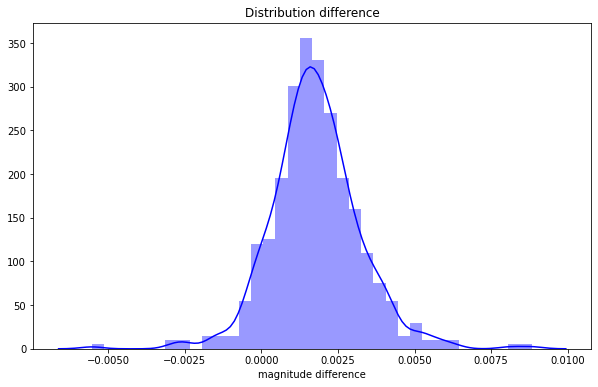

In [32]:
magnitude_difference = []
magnitude_perturbed_images1 = []
magnitude_perturbed_images2 = []

for i in range(0,len(perturbed_images1)):
  magnitude_difference.append(np.mean(perturbed_images1[i])-np.mean(perturbed_images2[i]))
  magnitude_perturbed_images1.append(np.mean(perturbed_images1[i]))
  magnitude_perturbed_images2.append(np.mean(perturbed_images2[i]))

print('average difference: ', np.mean(magnitude_difference))

fig = plt.figure(figsize=(10,6))
sns.distplot(magnitude_difference, color="blue")
plt.xlabel('magnitude difference')
plt.title('Distribution difference')

In the next code block, 6 examples are given of perturbed images and the predictions on these perturbed images. 3 of these images contain a person. A noticeable pattern occurs: in the images containing a person, the perturbations resemble subtile green smudges in order to fool the classifier that there is no person in the image, while for the images not containing a person, the perturbations are mostly pink or purple smudges in an attempt to fool the classifier that there is a person in the image. This shows that there's a slight bias towards classifying an image as ```person``` in the presence of pink/purple spots in the image. The opposite can be said about the green smudges. In the presence of these smudges, the classifier tends to classify the image as ```no person```. These green smudges also do not seem to appear randomly in the images, but are often at the location of the person in the original image.

This shows some weakpoints of the classifier and it is clear that the trained classifier is definitely not robust enough for practical use. However, these perturbed images can be reused as new training images for the classifier to improve its robustness of the task.

In [33]:
interesting_examples = [5,10,18,31,45,61]

for i in interesting_examples:
  img1 = np.concatenate((np.abs(np.subtract(perturbed_images1[i]*255,x_test_data_new[i])),perturbed_images1[i]*255),axis=1)
  img2 = np.concatenate((np.abs(np.subtract(perturbed_images2[i]*255,x_test_data_new[i])),perturbed_images2[i]*255),axis=1)
  cv2_imshow(np.concatenate((x_test_data_new[i],img1), axis=1))
  cv2_imshow(np.concatenate((x_test_data_new[i],img2), axis=1))
  print("prediction person in original image:           ", prediction[i], "- ground truth:", y_test_data[i])
  print("prediction person in perturbed image (model 1):", prediction_perturbed1[i], "- deceptive label:", y_test_data_deceptive[i])
  print("prediction person in perturbed image (model 2):", prediction_perturbed2[i], "- deceptive label:", y_test_data_deceptive[i])

Output hidden; open in https://colab.research.google.com to view.

##g. Conclusion

In this chapter, adversarial examples were covered, using an encoder-decoder structure to generate the perturbations. The overall approach was discussed and a comparative analysis was performed on the two different training sets. It can also be concluded that the performance of the adversarial is acceptable. Model 1 and model 2 are able to drop the performance of the classifier by 17% and 15% respectively, simply by perturbing the images with subtile smudges. The images still remain very recognizable for human observers.

This example might not be a very realistic set-up, since a white-box attack is discussed. For a white-box attack, it is assumed that the complete model and its weights are known. This might not always be the case. However, it will be explained soon that such an attack might still have a different purpose in the real-world than merely trying to break a classifier.

The used classifier was not very reliable to begin with, as it only had an accuracy of 73.80% on the original test set. This does not mean that the classifier can be not be improved further. The classifier can be made more robust by using these generated adversarial examples as new training data to tackle its weak points. Hence contrary to what was said before, this attack might still be used in a real world scenario, to improve robustness of your model, or in cases where the training set is very limited.

# **VI. Discussion**

##a. Classification
The binary classification was implemented using VGG16's architecture. The performance for the network trained from scratch was acceptable. The transfer learning showed better results as expected. The training set was extended by performing image augmentation. Further improvements that were not implemented are also possible, such as balancing the dataset (currently 20% more images without a person). This imbalance proved to be a limitation on the models, since both models tends to be biased towards classifying an image as "no person". As mentioned before, training a complex network from scratch (VGG16 with 27 million parameters) using a small dataset, might cause the model to be more sensitive to overfitting. To avoid this (and if we had more time), we could have started with a very simple model for the training from scratch and compare it to the more elaborate VGG16 model. We could also have experimented a bit more with the image augmentations. 


Another limitation of our classification models is that they can only classify if there is a person in the images. We did this because the dataset is inbalanced and does not have the same number images for every class. If we have more time, we would add more augmentation to the dataset to make a suitable dataset for a multi-class classification model. In the adversarial part, the classifier is fooled by adding perturbations and outputs wrong predictions. This indicates our classifier is not robust enough yet. To get a more reliable classifier that can handle such perturbations, we can retrain the classifier on the noised images and let it learn how to give correct predictions with perturbations. This more robust classifier will be more useful and reliable in the real world as the quality of the images from the cameras cannot be always guaranteed.

In a real world setting, person / no person classification can be really useful, e.g. for home security cameras.

##b. Segmentation
The binary segmentation part made use of a different structure than the classification. The structure used in the training from scratch was very similar to the existing structure. The results obtained from the trained from scratch segmentation model were decent but differed for varying images as can be seen in the good and bad examples part. Cluttering of the images played a huge part in the accuracy of the background-foreground segmentation. The results of using the pre-trained U-Net model gave better results in general. This could be party because of the skip connections used by U-Net and because of the pre-trained weights which might have been trained longer on more images.

In the current approach, improvements could be made by performing image augmentations on the available dataset. This would extend the current dataset, which is rather small at the moment.

Another limitation of the model is that the model is trained on data and labels not specifically meant for foreground-background segmentations. Hence, improvements are still possible by training the model on appropriate data. The model itself could also be improved by using skip connections as was proposed. The U-Net model uses this and appears to have better performance. Possiby adding dropout layers in the encoder-decoder structure could improve the results further.

If we had more time, we could have experimented with the transfer learning a bit more. Instead of completely freezing the encoder layers, we could have used the pretrained weights as initial guess, and using these weights to train the network further on our own dataset. This idea could also have been explored in the classification task. 

In a real world setting, foreground-background segmentation are useful for example in video conferencing, to emulate a green screen-effect.

##c. Adversarial

The adversarial task reached its goal. The performance of the targeted classifier was noticeably reduced, simply by generating subtle perturbations on the images. These perturbations were generated with a very light-weight convolutional encoder-decoder. 

If we had more time, we could have experimented with different encoder-decoder models, such as variational encoder-decoders or denoising encoder-decoders, or explored the effect of making the current model more complex by adding e.g. skip connections. 

In a real world setting, these adversarial examples can be used to extend the training set of the targeted model and improve its robustness.

# **VII. Extra: Multi-class semantic segmentation**

The task of semantic segmentation for multiple classes, can be summarized as follow: For each image pixel, predict the class of the object containing that pixel. 


In [34]:
voc_dir = '/content/VOCdevkit/VOC2009' 

#for convenience, we set a square 256x256 image size as the input size of the network. Images in the dataset are usually max 500px wide 
im_rows = 256
im_cols = 256

def read_voc_images(voc_dir, is_train=True):
    """Read all VOC feature and label images."""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation', 'train.txt' if is_train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    
    features, masks = [], []
    n_classes = 21

    for i, fname in enumerate(images):
        
        current_img = cv2.cvtColor(cv2.imread(os.path.join(voc_dir, 'JPEGImages', '%s.jpg' % fname)), cv2.COLOR_BGR2RGB)
        #add the following line to resize images to fit network
        current_img = cv2.resize(current_img, dsize=(im_rows,im_cols))
        features.append(current_img)

        current_mask = cv2.cvtColor(cv2.imread(os.path.join(voc_dir, 'SegmentationClass', '%s.png' % fname)), cv2.COLOR_BGR2RGB)
        #add the following line to resize images masks to fit network
        current_mask = cv2.resize(current_mask, dsize=(im_rows,im_cols))
        masks.append(current_mask)

    features = np.array(features)
    masks = np.array(masks)

    return features, masks

#populate two arrays 
train_features, train_masks = read_voc_images(voc_dir, True)
val_features, val_masks = read_voc_images(voc_dir, False)

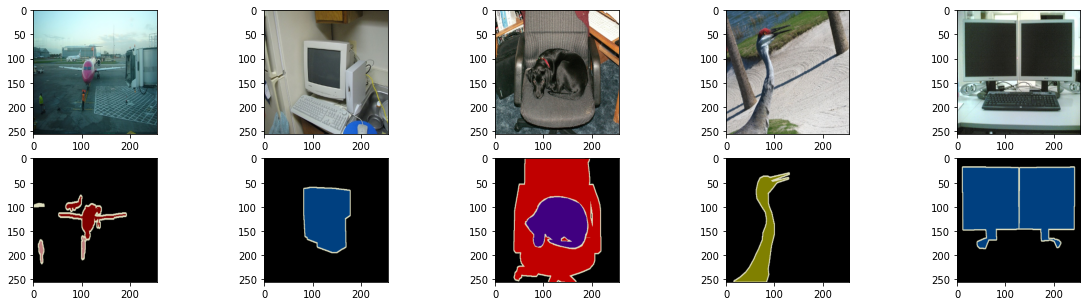

In [35]:
#create a figure to show some images from the TRAINING set and their respective segmentation masks
fig = plt.figure(figsize=(20,5))
columns = 5
rows = 2
for i in range(rows*columns):
    fig.add_subplot(rows, columns, i+1)
    if i < columns:
        plt.imshow(train_features[i])
    else:
        plt.imshow(train_masks[i-columns])
plt.show()

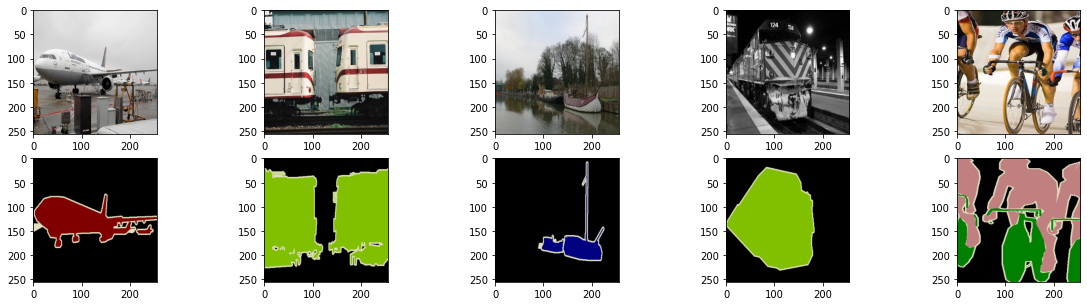

In [36]:
#create a figure to show some images from the VALIDATION set and their respective segmentation masks

fig = plt.figure(figsize=(20,5))
columns = 5
rows = 2
for i in range(rows*columns):
    fig.add_subplot(rows, columns, i+1)
    if i < columns:
        plt.imshow(val_features[i])
    else:
        plt.imshow(val_masks[i-columns])
plt.show()


##a. Organize Dataset

### Inputs
The input data for semantic segmentaion are regular images. In our case Jpeg files from Pascal VOC 2009 dataset. 

### Labels
The labels can come in different forms. 

* _A_ Greyscale images semantic masks.  where pixel intensity represents the class. Easy to work with, little to no preprocessing requires
* _B_ RGB images semantic masks. The different classes have each a unique RGB encoding. Convenient for human consumption. Requires pre processing to map RGB values to class labels or one hot encodings. 
* _C_ One hote encoding. Each pixel is encoded as a one hot vector, with a value of 1 for the class it represent, 0 elsewhere. The best and most readily compatible way to use semantic labels

Pascal VOC dataset express semantic segmentation labels as .png files depicting the RGB masks for each object class. We will pre-process the labels to turn them into a one-hot encoding representation to fit with the output of the model of choice. 

### Output of the Segmentation Model

A Tensor of shape [[n_samples, height, width, n_classes]]. _height_ and _width_ are the same of the input images. _nclasses_ contains the predicted probability distributions of each class for any pixel following the one-hot input vector encodings. 

![alt text](https://drive.google.com/uc?id=1xrlH69cxcyDhpYu1hdgPWVj-wxcmytVz)

In [37]:
# array with the class names of the 20 categories
seg_classes = np.array(["background","aeroplane","bicycle","bird","boat","bottle","bus","car","cat","chair","cow","diningtable","dog","horse","motorbike","person","pottedplant","sheep","sofa","train","tvmonitor"])

seg_classes_n = np.arange(21)

#list with the unique color maps of the segmentation masks given here: https://d2l.ai/chapter_computer-vision/semantic-segmentation-and-dataset.html 
seg_colormap = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

In [38]:
color_dict = dict(zip(seg_classes, seg_colormap))
colormap_dict = dict(zip(seg_classes_n, seg_colormap))
print('Dictionary of classes name and their respective RGB encoding', color_dict)
print('Dictionary of classes # identifier and their respective RGB encoding', colormap_dict)

Dictionary of classes name and their respective RGB encoding {'background': [0, 0, 0], 'aeroplane': [128, 0, 0], 'bicycle': [0, 128, 0], 'bird': [128, 128, 0], 'boat': [0, 0, 128], 'bottle': [128, 0, 128], 'bus': [0, 128, 128], 'car': [128, 128, 128], 'cat': [64, 0, 0], 'chair': [192, 0, 0], 'cow': [64, 128, 0], 'diningtable': [192, 128, 0], 'dog': [64, 0, 128], 'horse': [192, 0, 128], 'motorbike': [64, 128, 128], 'person': [192, 128, 128], 'pottedplant': [0, 64, 0], 'sheep': [128, 64, 0], 'sofa': [0, 192, 0], 'train': [128, 192, 0], 'tvmonitor': [0, 64, 128]}
Dictionary of classes # identifier and their respective RGB encoding {0: [0, 0, 0], 1: [128, 0, 0], 2: [0, 128, 0], 3: [128, 128, 0], 4: [0, 0, 128], 5: [128, 0, 128], 6: [0, 128, 128], 7: [128, 128, 128], 8: [64, 0, 0], 9: [192, 0, 0], 10: [64, 128, 0], 11: [192, 128, 0], 12: [64, 0, 128], 13: [192, 0, 128], 14: [64, 128, 128], 15: [192, 128, 128], 16: [0, 64, 0], 17: [128, 64, 0], 18: [0, 192, 0], 19: [128, 192, 0], 20: [0, 64,

In [39]:
def onehot_encoding (mask, clr_dict):
    """ function that maps a rgb semantic color mask for the full image into a one-hot encoding

        mask is an rgb array representing a .png image of a semantic mask // mask = numpy.array(image height, image width, 3)
        clr_dict is a dictionary containing the key value pairs of a semantic mask [integer 0 <key < #of classes] and its RGB encoding [an array (1,3)]""" 
    
    #added also this line to treat the boundaries of the semantic objects masks as background. remove if not necessary later for experimentation
    mask[np.all(mask == (255, 255, 255), axis=-1)] = (0,0,0)
    # -----------------------------

    h = mask.shape[0]
    w = mask.shape[1]
    c = len(clr_dict)
    onehot = np.zeros((h, w, c), dtype=np.int8)

    for i, clrs in enumerate(clr_dict):
        bolmap = np.all(mask.reshape((-1,3)) == clr_dict[i], axis=1)
        onehot[:,:,i] = bolmap.reshape((h,w))

    return onehot 


def onehot_to_RGB (onehot_encoded_mask, clr_dict):
    """ function that maps a one-hot encoded color mask into an rgb image following a dictionary

        onehot_encoded_mask is a numpy array representing a one hot encoded image of a semantic mask // onehot-encoded_mask  = numpy.array(image height, image width, n_classes)
        clr_dict is a dictionary containing the key value pairs of a semantic mask [integer 0 < key < #of classes] and its RGB encoding [an array of shape (1,3)]""" 

    h = onehot_encoded_mask.shape[0]
    w = onehot_encoded_mask.shape[1]
    c = 3
    rgb_output = np.zeros((h,w,c), dtype=np.int8) 

    single_layer = np.argmax(onehot_encoded_mask, axis =-1)
    for k in clr_dict.keys():
        rgb_output[single_layer == k] = clr_dict[k]

    return np.uint8(rgb_output)


In [40]:
#perform one-hot encoding on all the .png mask images in the training set. 
onehot_train = []

for i in range(len(train_masks)):
    onehot_train.append(onehot_encoding(train_masks[i], colormap_dict))

#perform one-hot encoding on all the .png mask images in the validation set
onehot_val = []

for v in range(len(val_masks)):
    onehot_val.append(onehot_encoding(val_masks[v], colormap_dict)) 

onehot_train = np.array(onehot_train)
onehot_val = np.array(onehot_val)

#sanity check on dimensions
print('train feat',train_features.shape)
print('train masks onehot', onehot_train.shape)
print('val feat', val_features.shape)
print('val masks onehot', onehot_val.shape)

train feat (749, 256, 256, 3)
train masks onehot (749, 256, 256, 21)
val feat (750, 256, 256, 3)
val masks onehot (750, 256, 256, 21)


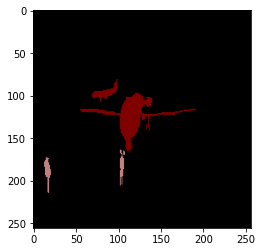

In [41]:
#sanity check on the one hot encoding decoding success 

example = cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(voc_dir, 'SegmentationClass', '2007_000032.png')), cv2.COLOR_BGR2RGB), dsize=(im_rows,im_cols))

tester = onehot_encoding(example, colormap_dict)

detester = onehot_to_RGB(tester, colormap_dict)

plt.imshow(detester)

##b. Building the Model

For the Multi class semantic segmentation task, we decided to use a U-net model, which has been developed to achieve better segmentation results than a FCN model (especially in biomedical images). U-net has already been explained in Section IV.

Our model of choice uses long skip connections in order to allow information captured in early layers to flow directly to deeper layers in the transposed convolutions steps. Skip connections also help in avoiding the vanishing gradients issue. 

In [42]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import MeanIoU

#Build U-Net model adapted from https://www.kaggle.com/advaitsave/tensorflow-2-nuclei-segmentation-unet 

inputs = Input(shape=(im_rows, im_cols, 3))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
c5 = BatchNormalization()(c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = BatchNormalization()(c6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
c6 = BatchNormalization()(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = BatchNormalization()(c7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
c7 = BatchNormalization()(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = BatchNormalization()(c8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
c8 = BatchNormalization()(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = BatchNormalization()(c9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
c9 = BatchNormalization()(c9)

outputs = Conv2D(21, (1, 1), activation='softmax') (c9)

print(outputs.shape)

(None, 256, 256, 21)


### Compiling the model

Loss function: "Categorical Crossentropy" since labels are provided as a one-hot encoded representation and there are multi-class predictions to be made

In [43]:
seg_unet = Model(inputs=[inputs], outputs=[outputs])
seg_unet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalCrossentropy()])
seg_unet.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 256, 256, 32) 896         lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 256, 256, 32) 128         conv2d_14[0][0]                  
____________________________________________________________________________________________

##c. Fitting the model 

At this stage we will fit the model giving it as imput the RGB images of the semantic segmentation training set, together with the one-hot encoded representation of their respective training semantic masks. 

In [44]:
#fit model

#checkpoint_path = '/content/saved_models/cp.ckpt'
#checkpoint_dir = os.path.dirname(checkpoint_path)

#earlystopper = tf.keras.callbacks.EarlyStopping(patience=15, verbose=1)
#checkpointer = ModelCheckpoint('model_unet_checkpoint.h5', verbose=1, save_best_only=True)
#results = seg_unet.fit(train_features, onehot_train, batch_size=32, epochs=200, validation_data=(val_features, onehot_val))
#seg_unet.save('/content/saved_models/unet.h5')

##d. Make Predictions

The weights are loaded and predictions on example images are performed.

In [45]:
from tensorflow.keras.models import load_model

#!wget -nc https://www.dropbox.com/s/arjbz1q5pjsbpot/unet_200ep_catcross.h5

seg_model = load_model('/content/unet_200ep_catcross.h5')

In [46]:
preds_train = seg_model.predict(train_features[:10], verbose=1)
preds_val = seg_model.predict(val_features[:10], verbose=1)

1/1 [==============================] - 0s 2ms/step


##e. Visualize results 

The predictions are now visualized.

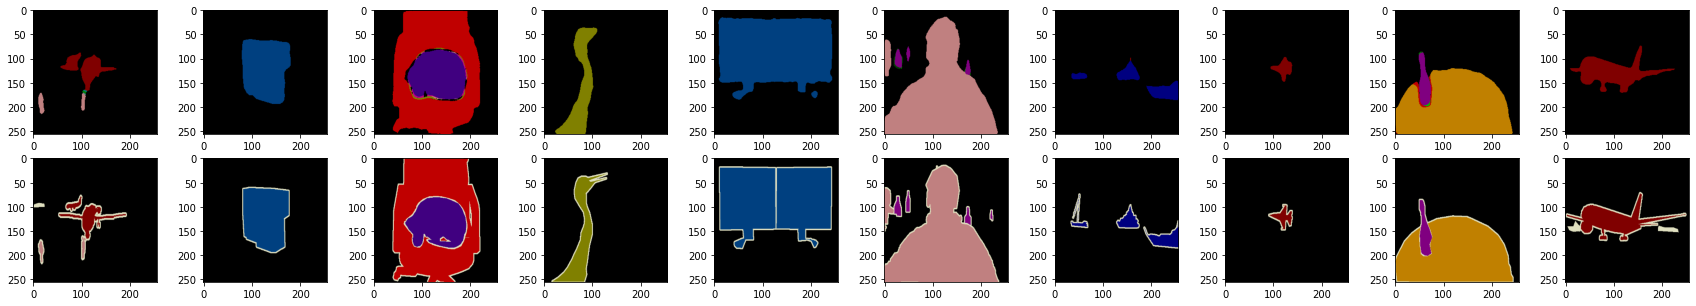

In [47]:
#create a figure to show some predictions from the TRAINING set and their respective segmentation masks
fig = plt.figure(figsize=(30,5))
columns = 10
rows = 2
for i in range(rows*columns):
    fig.add_subplot(rows, columns, i+1)
    if i < columns:
        plt.imshow(onehot_to_RGB(preds_train[i], colormap_dict))
    else:
        plt.imshow(train_masks[i-columns])
plt.show()

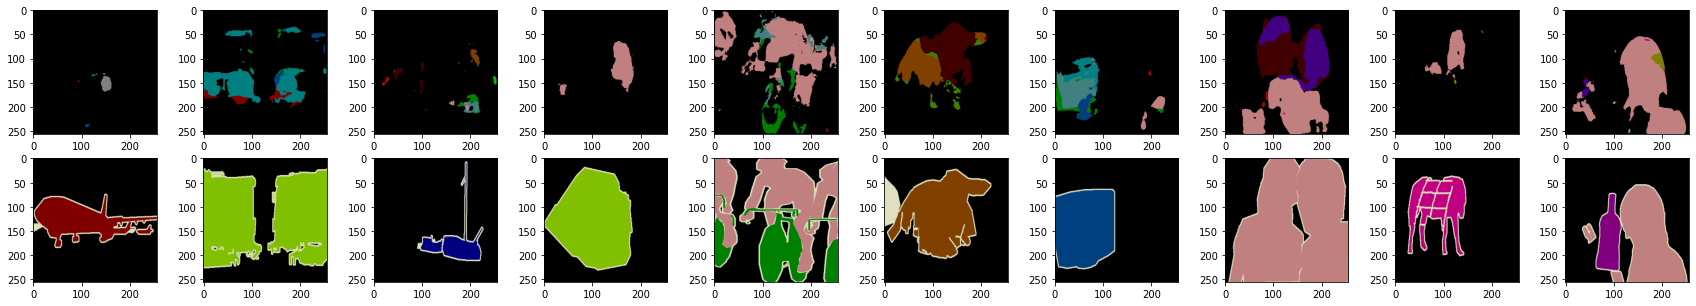

In [48]:
#create a figure to show some predictions from the VALIDATION set and their respective segmentation masks
fig = plt.figure(figsize=(30,5))
columns = 10
rows = 2
for i in range(rows*columns):
    fig.add_subplot(rows, columns, i+1)
    if i < columns:
        plt.imshow(onehot_to_RGB(preds_val[i], colormap_dict))
    else:
        plt.imshow(val_masks[i-columns])
plt.show()

##f. Discussion and results

Visually, results on the training set are very encouraging. On the other hand, the predictions on the validation set are way off. This can show an overfitting problem on training set, despite the use of batch norm and dropout techniques to avoid it to happen. 

From the result we can see that certain classes are predicted slightly better than others, for example "person" seem to have a little bit better predictions than "train" or "aeroplane".

A few nobs that we could tweak to solve the issue if we had more time:
* Perform data augmentation on the set, adding rotated and cropped images for example
* Weigh the contribution of the classes according to their predominancy in the dataset to make sure that the underrepresented classes are as relevant as the over represented ones

Another approach could also be to start with a simpler model. As mentioned before, complex models are sensitive to overfitting when only a small dataset is available.

